# Предсказание продолжительности поездки на такси

## 1. Постановка задачи


В рамках данного проекта нам предстоит решить [настоящую задачу машинного обучения](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/), направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 


Представьте, вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

import xgboost as xgb

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки на несколько групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала посмотрим на временные рамки, в которых мы работаем с данными.

In [3]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].describe()

/var/folders/jf/3hxfbhy54t1_08mj093gdp940000gn/T/ipykernel_95584/810657438.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  taxi_data['pickup_datetime'].describe()


count                 1458644
unique                1380222
top       2016-03-04 08:07:34
freq                        5
first     2016-01-01 00:00:17
last      2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

Представленные данные содержат информацию за период с 01-01-2016 по 30-06-2016, т.е. первое полугодие 2016 года.

In [4]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


Пропуски в данных отсутствуют.

Посмотрим на статистические характеристики признаков. 


In [5]:
taxi_data['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

Признак 'vendor_id' имеет целочисленный тип, при этом принимает только 2 значения: 1 и 2. То есть данный признак можно отнести к категоральным.

In [6]:
taxi_data.describe(include='all')

/var/folders/jf/3hxfbhy54t1_08mj093gdp940000gn/T/ipykernel_95584/2726144569.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  taxi_data.describe(include='all')


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2875421,NaN,2016-03-04 08:07:34,2016-02-19 19:25:04,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
first,NaN,NaN,2016-01-01 00:00:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.534950e+00,NaN,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
std,NaN,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,NaN,5.237432e+03
min,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,NaN,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Реализуем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

In [7]:
#функция преобразования даты
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

taxi_data = add_datetime_features(taxi_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday


Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

In [8]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date']).dt.date

def add_holiday_features(taxi_data, holiday_data):
    merged_data = taxi_data.merge(
        holiday_data, 
        how='left', 
        left_on='pickup_date', 
        right_on='date'
    )
    merged_data['pickup_holiday'] = merged_data['holiday'].apply(
        lambda x: 1 if x is not np.NaN else 0
    )
    merged_data.drop(['day','date','holiday'], axis=1, inplace=True)
    return merged_data

taxi_data = add_holiday_features(taxi_data=taxi_data, holiday_data=holiday_data)
taxi_data.head()
    

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0


In [9]:
taxi_data.groupby('pickup_holiday')['trip_duration'].mean()

pickup_holiday
0    962.829482
1    867.610207
Name: trip_duration, dtype: float64

Средняя продолжительность поездки в праздничные дни меньше, чем в обычные.

Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [10]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
osrm_data = osrm_data[['id','total_distance', 'total_travel_time', 'number_of_steps']]

def add_osrm_features(taxi_data, osrm_data):
    merged_data = taxi_data.merge(osrm_data, how='left', on='id')
    return merged_data

taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0


In [11]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

В результате объединения таблиц у нас получились пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

In [12]:
#функция для вычисления расстояния между двумя точками по формуле гаверсинуса (в километрах)
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

#функция для вычисления угла направления движения (в градусах)
def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.


In [13]:
def add_geographical_features(taxi_data):
    taxi_data['haversine_distance'] = taxi_data.apply(
        lambda x: get_haversine_distance(
            x.pickup_latitude,
            x.pickup_longitude,
            x.dropoff_latitude,
            x.dropoff_longitude
        ),
        axis=1
    
    )
    taxi_data['direction'] = taxi_data.apply(
        lambda x: get_angle_direction(
            x.pickup_latitude,
            x.pickup_longitude,
            x.dropoff_latitude,
            x.dropoff_longitude
        ),
        axis=1
    )
    return taxi_data

taxi_data = add_geographical_features(taxi_data)
taxi_data.head()  

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585


Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [14]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

#функция для создания признака кластера
def add_cluster_features(taxi_data, model_cluster):
    y = model_cluster.predict(np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                                         taxi_data[['dropoff_latitude', 'dropoff_longitude']])))
    y = pd.DataFrame(y, columns=['cluster'])
    taxi_data['geo_cluster'] = y['cluster']
    return taxi_data

taxi_data = add_cluster_features(taxi_data, kmeans)
taxi_data.head()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,Monday,0,2009.1,164.9,5.0,1.498521,99.970196,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,Sunday,0,2513.2,332.0,6.0,1.805507,-117.153768,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,Tuesday,0,11060.8,767.6,16.0,6.385098,-159.680165,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,Wednesday,0,1779.4,235.8,4.0,1.485498,-172.737700,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,Saturday,0,1614.9,140.1,5.0,1.188588,179.473585,9


In [15]:
taxi_data['geo_cluster'].value_counts()

0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

Получили 10 географических кластеров с помощью алгоритма KMeans

Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [16]:
weather_data = pd.read_csv('data/weather_data.csv')
weather_data['time'] = pd.to_datetime(weather_data['time'], format='%Y-%m-%d %H:%M:%S')
weather_data['date'] = weather_data['time'].dt.date
weather_data['hour'] = weather_data['time'].dt.hour
weather_data = weather_data[['date', 'hour', 'temperature', 'visibility', 
              'wind speed', 'precip', 'events']]
weather_data.head()

,date,hour,temperature,visibility,wind speed,precip,events
0,2015-12-31,2,7.8,8.0,5.6,0.8,None
1,2015-12-31,3,7.2,12.9,7.4,0.3,None
2,2015-12-31,4,7.2,12.9,0.0,0.0,None
3,2015-12-31,5,7.2,14.5,7.4,0.0,None
4,2015-12-31,6,7.2,11.3,5.6,0.0,None


In [17]:
def add_weather_features(taxi_data, weather_data):
    merged_data = taxi_data.merge(
        weather_data, 
        how='left',
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour']
    )
    merged_data.drop(['date', 'hour'], axis=1, inplace=True)
    return merged_data

taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None


In [18]:
taxi_data['events'].value_counts()

None    1375185
Rain      58300
Snow      13126
Fog           1
Name: events, dtype: int64

In [19]:
taxi_data.isnull().mean()*100

id                    0.000000
vendor_id             0.000000
pickup_datetime       0.000000
dropoff_datetime      0.000000
passenger_count       0.000000
pickup_longitude      0.000000
pickup_latitude       0.000000
dropoff_longitude     0.000000
dropoff_latitude      0.000000
store_and_fwd_flag    0.000000
trip_duration         0.000000
pickup_date           0.000000
pickup_hour           0.000000
pickup_day_of_week    0.000000
pickup_holiday        0.000000
total_distance        0.000069
total_travel_time     0.000069
number_of_steps       0.000069
haversine_distance    0.000000
direction             0.000000
geo_cluster           0.000000
temperature           0.824876
visibility            0.824876
wind speed            0.824876
precip                0.824876
events                0.824876
dtype: float64

В результате объединения у нас получились записи, для которых в столбцах temperature, visibility, wind speed, precip, и events пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

Реализуем функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах следующим образом:

- Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки.  
- Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 
- Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 


In [20]:
def fill_null_weather_data(taxi_data):
    columns = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in columns:
        taxi_data[col] = taxi_data[col].fillna(
            taxi_data.groupby('pickup_date')[col].transform('median')
        )
    taxi_data = taxi_data.fillna(
        {'events': 'None',
         'total_distance': taxi_data['total_distance'].median(), 
         'total_travel_time': taxi_data['total_travel_time'].median(), 
         'number_of_steps': taxi_data['number_of_steps'].median()}
    )
    return taxi_data

taxi_data = fill_null_weather_data(taxi_data)
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        0
total_travel_time     0
number_of_steps       0
haversine_distance    0
direction             0
geo_cluster           0
temperature           0
visibility            0
wind speed            0
precip                0
events                0
dtype: int64

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Выбросами будем считать поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Будем считать выбросами только последнюю группу. Для обнаружения таких выбросов воспользуемся информацией о кратчайшем расстоянии, которое проезжает такси, вычислим среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$

Построим диаграмму рассеяния средней скорости движения автомобилей:


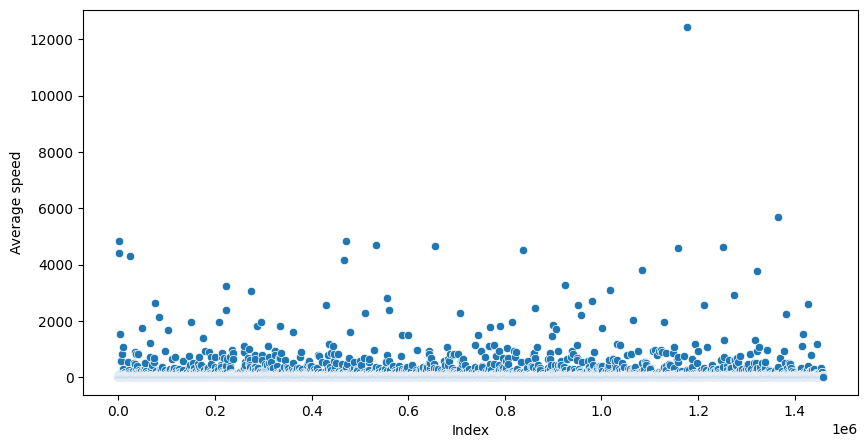

In [21]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


Удалим выбросы по условию: длительность превышает 24 часа или скорость выше 300 км/ч.

In [22]:
mask1 = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 > 300
mask2 = taxi_data['trip_duration'] > 24 * 3600
taxi_data = taxi_data.drop(index=taxi_data[mask1 | mask2].index)

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование.


Начинаем с целевого признака. 

Основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где log - натуральный логарифм.


In [23]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 

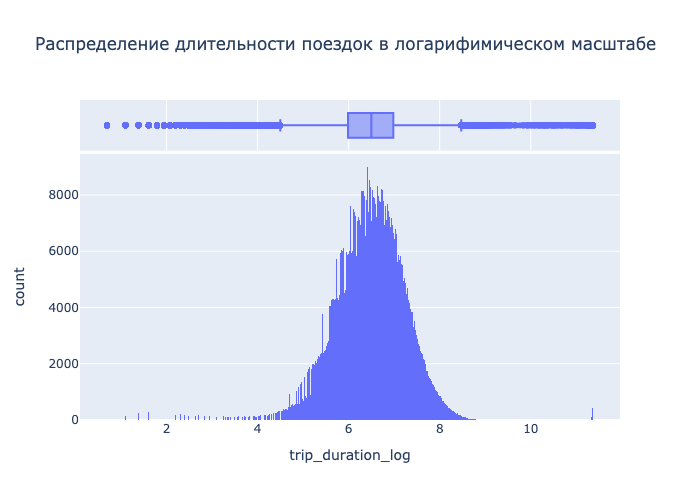

In [33]:
fig = px.histogram(taxi_data, x = 'trip_duration_log', marginal = 'box',
                   title ='Распределение длительности поездок в логарифимическом масштабе')
fig.show("png")

На основании построенного графика, можно сделать предположение, что распределение длительности поездок в логарифмическом масштабе является нормальным. Проверим это с помощью статистического теста Д'Агостино.

In [ ]:
# задаём уровень значимости
alpha = 0.05 

# проводим тест Шапиро-Уилка
_, p = stats.normaltest(taxi_data['trip_duration_log'])

print('p-value = ',p)

# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value =  0.0
Распределение не нормальное


 Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

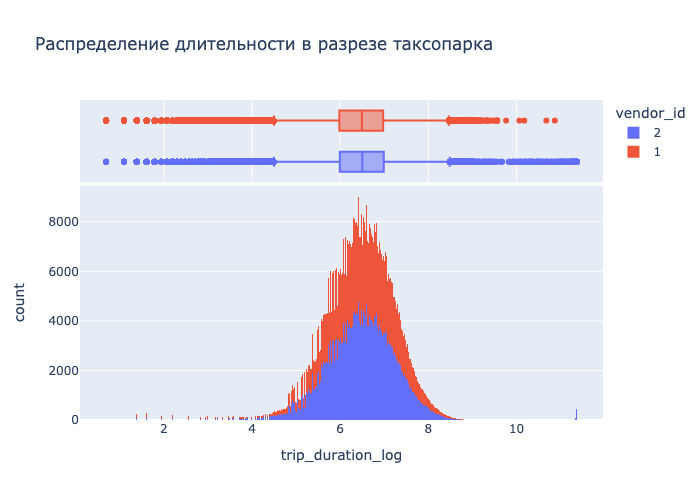

In [34]:
fig = px.histogram(taxi_data, x = 'trip_duration_log', marginal = 'box',
                   color='vendor_id',
                   title ='Распределение длительности в разрезе таксопарка')
fig.show("png")

Распределения в группах практически не отличаются, можно предположить, что признак vendor_id не имеет значения при определении длительности поездки.

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

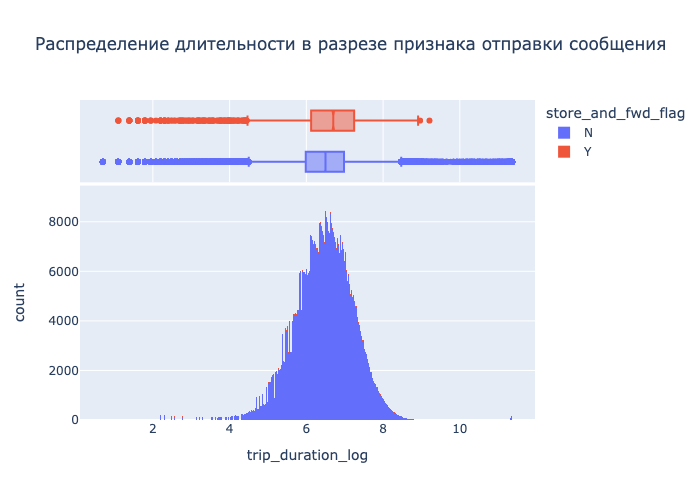

In [35]:
fig = px.histogram(taxi_data, x = 'trip_duration_log', marginal = 'box',
                   color='store_and_fwd_flag',
                   title ='Распределение длительности в разрезе признака отправки сообщения')
fig.show("png")

Распределения длительности поездки в разрезе признака отправки сообщения поставщику отличаются: для случая отправки сообщения медиана длительности выше, при этом отсутствует большое количество выбросов справа - поездки с очень большой длительностью.

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

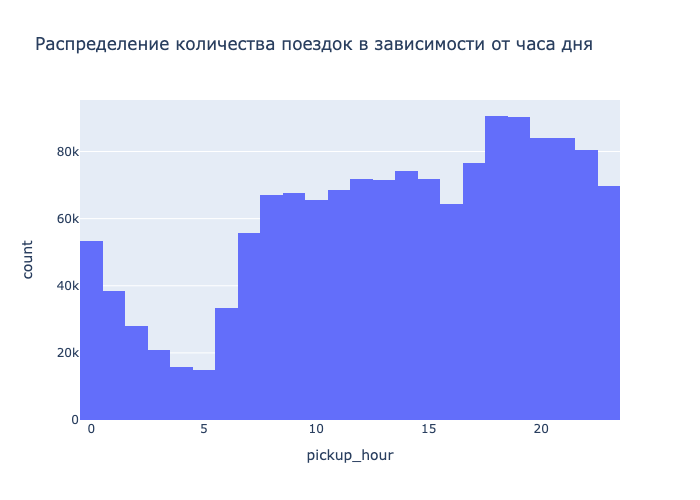

In [36]:
fig = px.histogram(taxi_data, x='pickup_hour', 
             title='Распределение количества поездок в зависимости от часа дня')
fig.show('png')

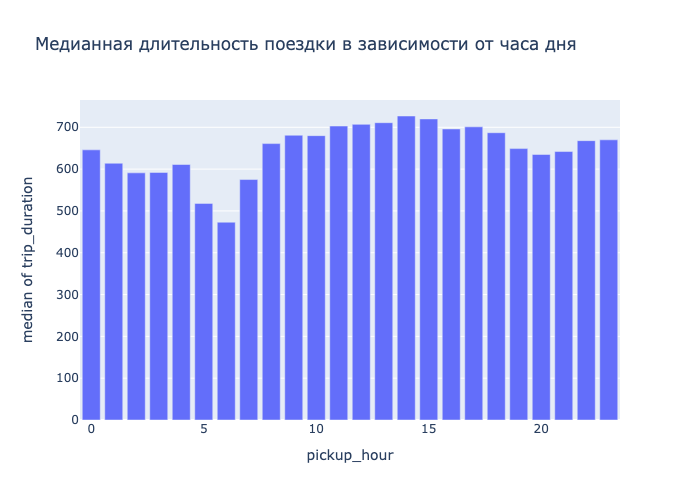

In [37]:
data = taxi_data.groupby('pickup_hour')['trip_duration'].median()
fig = px.bar(data, x=data.index, y=data.values,
                   title='Медианная длительность поездки в зависимости от часа дня',
                   labels={'y':'median of trip_duration'})
fig.show("png")

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

In [ ]:
fig = px.histogram(taxi_data, x='pickup_day_of_week', 
             title='Распределение количества поездок в зависимости от дня недели')
fig.show("png")

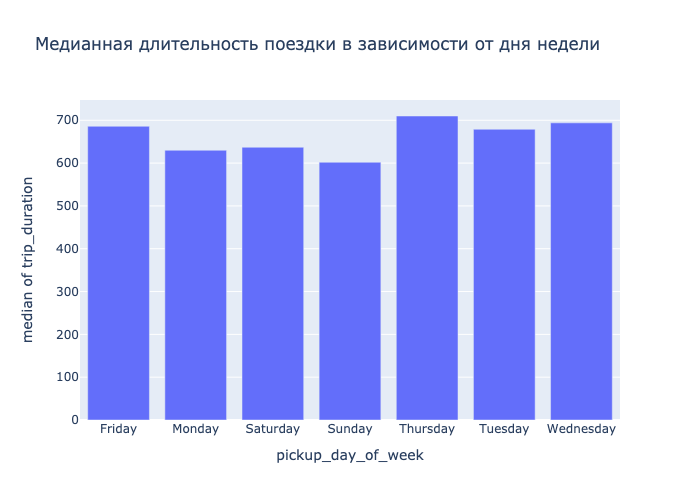

In [55]:
data = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()
fig = px.bar(data, x=data.index, y=data.values,
                   title='Медианная длительность поездки в зависимости от дня недели',
                   labels={'y':'median of trip_duration'})
fig.show("png")

Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

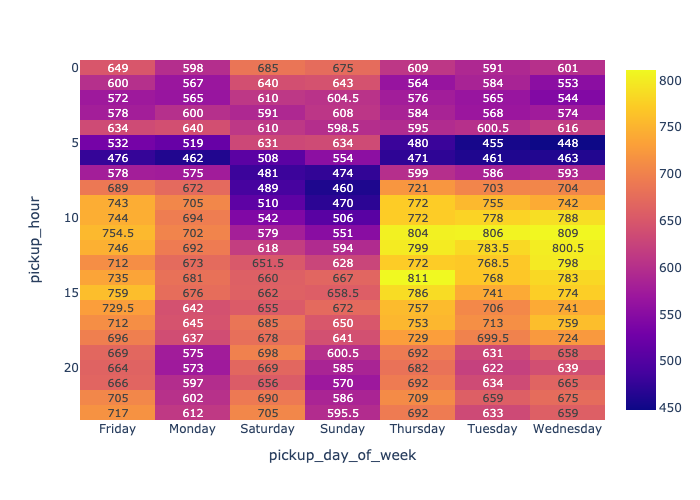

In [56]:
pivot_table = pd.pivot_table(taxi_data, values='trip_duration', columns='pickup_day_of_week',
                             index='pickup_hour', aggfunc='median')
fig = px.imshow(pivot_table, text_auto=True)
fig.show("png")

Построим две диаграммы рассеяния (scatter-диаграммы):
* первая будет иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая - географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 


In [ ]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

mask1 = (taxi_data['pickup_latitude'] < city_lat_border[1]) & (taxi_data['pickup_latitude'] > city_lat_border[0])
mask2 = (taxi_data['pickup_longitude'] < city_long_border[1]) & (taxi_data['pickup_longitude'] > city_long_border[0])
data = taxi_data[mask1 & mask2]

fig = px.scatter_geo(data, lat='pickup_latitude', lon='pickup_longitude', color='geo_cluster')
fig.show("png")

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, выполним следующие шаги:
* Преобразуем категоральные признаки;
* Отберем признаки, которые мы будем использовать для обучения модели;
* Масштабируем и трансформируем некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [24]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [25]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [26]:
drop_columns = ['id', 'dropoff_datetime', 'pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

In [27]:
train_data['vendor_id'] = train_data['vendor_id'].apply(
    lambda x: 0 if x == 1 else 1
)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag']. apply(
    lambda x: 0 if x == 'N' else 1
)

Создадим таблицу  'data_onehot' из закодированных OneHot признаков pickup_day_of_week, geo_cluster и events в таблице train_data. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

In [28]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster','events']
one_hot_encoder = preprocessing.OneHotEncoder(drop='first', sparse_output=False)
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change])
column_names = one_hot_encoder.get_feature_names_out()
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
data_onehot.head()

,pickup_day_of_week_Monday,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками:

In [29]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [30]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [31]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе.


In [32]:
select_feature = feature_selection.SelectKBest(
    score_func=feature_selection.f_regression, 
    k=25
)
select_feature.fit(X_train, y_train_log)
X_selected_train = select_feature.transform(X_train)
X_selected_valid = select_feature.transform(X_valid)
select_feature.get_feature_names_out()
column_kbest=select_feature.get_feature_names_out()
column_kbest

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_Monday',
       'pickup_day_of_week_Saturday', 'pickup_day_of_week_Sunday',
       'pickup_day_of_week_Thursday', 'pickup_day_of_week_Tuesday',
       'pickup_day_of_week_Wednesday', 'geo_cluster_1', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler.


In [33]:
m_scaler = preprocessing.MinMaxScaler()
m_scaler.fit(X_selected_train)
X_train_scaled = m_scaler.transform(X_selected_train)
X_valid_scaled = m_scaler.transform(X_selected_valid)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Метрика, по которой мы будем измерять качество наших моделей - RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Построим модель линейной регрессии.

In [34]:
res = {}
linreg = linear_model.LinearRegression()
linreg.fit(X_train_scaled, y_train_log)
y_train_pred = linreg.predict(X_train_scaled)
y_valid_pred = linreg.predict(X_valid_scaled)
print("RMSE for train:", metrics.mean_squared_error(y_pred=y_train_pred, 
                                                    y_true=y_train_log)**0.5)
print("RMSE for valid:", metrics.mean_squared_error(y_pred=y_valid_pred, 
                                                    y_true=y_valid_log)**0.5)
res['linreg'] = metrics.mean_squared_error(y_pred=y_valid_pred, 
                                           y_true=y_valid_log)**0.5


RMSE for train: 0.5356435185027016
RMSE for valid: 0.5380984271876291


Сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures.

Построим модель полиномиальной регрессии 2-ой степени.


In [35]:
poly = preprocessing.PolynomialFeatures(include_bias=False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly.transform(X_valid_scaled)
linreg_poly = linear_model.LinearRegression()
linreg_poly.fit(X_train_scaled_poly, y_train_log)
y_train_pred = linreg_poly.predict(X_train_scaled_poly) 
y_valid_pred = linreg_poly.predict(X_valid_scaled_poly)
print("RMSE for train:", metrics.mean_squared_error(y_pred=y_train_pred, 
                                                    y_true=y_train_log)**0.5)
print("RMSE for valid:", metrics.mean_squared_error(y_pred=y_valid_pred, 
                                                    y_true=y_valid_log)**0.5)
res['linreg_poly'] = metrics.mean_squared_error(y_pred=y_valid_pred, 
                                           y_true=y_valid_log)**0.5

RMSE for train: 0.4663724305432209
RMSE for valid: 0.7003935737160042


Для данной модели наблюдается переобучение: значение метрики на валидационной выборке сильно меньше, чем на обучающей.

Для борьбы с переобучением построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову).


In [36]:
polyreg_l2 = linear_model.Ridge()
polyreg_l2.fit(X_train_scaled_poly, y_train_log)
y_train_pred = polyreg_l2.predict(X_train_scaled_poly) 
y_valid_pred = polyreg_l2.predict(X_valid_scaled_poly)
print("RMSE for train:", metrics.mean_squared_error(y_pred=y_train_pred, 
                                                    y_true=y_train_log)**0.5)
print("RMSE for valid:", metrics.mean_squared_error(y_pred=y_valid_pred, 
                                                    y_true=y_valid_log)**0.5)
res['polyreg_l2'] = metrics.mean_squared_error(y_pred=y_valid_pred, 
                                           y_true=y_valid_log)**0.5


RMSE for train: 0.4770545897474275
RMSE for valid: 0.4805061821586937


Переобучение удалось побороть, и качество модели улучшилось по сравнению с линейной моделью на исходных признаках.

Построим модель дерева решений.


In [37]:
dtr = tree.DecisionTreeRegressor()
dtr.fit(X_train_scaled, y_train_log)
y_train_pred = dtr.predict(X_train_scaled)
y_valid_pred = dtr.predict(X_valid_scaled)
print("RMSE for train:", metrics.mean_squared_error(y_pred=y_train_pred, 
                                                    y_true=y_train_log)**0.5)
print("RMSE for valid:", metrics.mean_squared_error(y_pred=y_valid_pred, 
                                                    y_true=y_valid_log)**0.5)
res['DecisionTree'] = metrics.mean_squared_error(y_pred=y_valid_pred, 
                                           y_true=y_valid_log)**0.5

RMSE for train: 0.003049191583639303
RMSE for valid: 0.5650622056566064


Мы получили переобученную модель, так как не ограничили деревья по глубине или количеству экземпляров в листе.

Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

In [38]:
rmse_tree = []
for max_depth in range(7,20):
    dtr = tree.DecisionTreeRegressor(max_depth=max_depth)
    dtr.fit(X_train_scaled, y_train_log)
    y_train_pred = dtr.predict(X_train_scaled)
    y_valid_pred = dtr.predict(X_valid_scaled)
    rmse_tree.append({
        'max_depth': max_depth,
        'rmse_train': metrics.mean_squared_error(y_pred=y_train_pred, 
                                                 y_true=y_train_log)**0.5,
        'rmse_valid': metrics.mean_squared_error(y_pred=y_valid_pred, 
                                                 y_true=y_valid_log)**0.5
    })
rmse_tree = pd.DataFrame(rmse_tree)

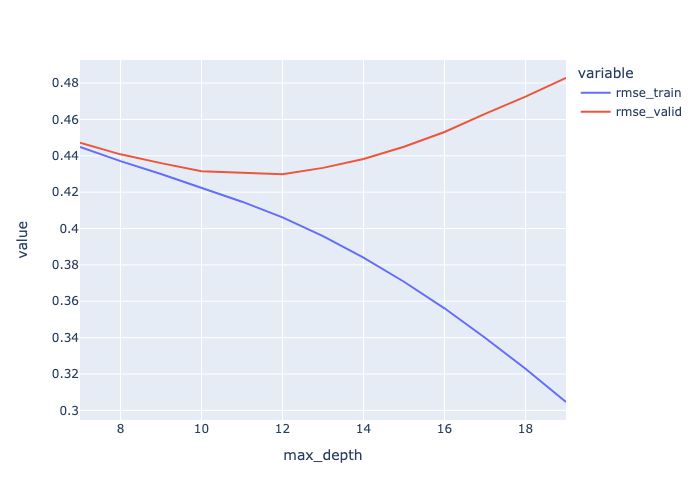

In [39]:
fig = px.line(rmse_tree, x='max_depth', y =['rmse_train', 'rmse_valid'])
fig.show('png')

In [40]:
res['DecisionTree'] = rmse_tree['rmse_valid'].min()

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Построим модель случайного леса. В качестве гиперпараметров будем использовать следующие значения:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42


In [42]:
rfr = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
)
rfr.fit(X_train_scaled, y_train_log)
y_train_pred = rfr.predict(X_train_scaled)
y_valid_pred = rfr.predict(X_valid_scaled)
print("RMSE for train:", metrics.mean_squared_error(y_pred=y_train_pred, 
                                                    y_true=y_train_log)**0.5)
print("RMSE for valid:", metrics.mean_squared_error(y_pred=y_valid_pred, 
                                                    y_true=y_valid_log)**0.5)
res['RandomForest'] = metrics.mean_squared_error(y_pred=y_valid_pred, 
                                           y_true=y_valid_log)**0.5


RMSE for train: 0.3992518537547931
RMSE for valid: 0.4141143423432189


Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor).

В качестве гиперпараметров укажим следующие значения:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42


In [43]:
gbr = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42
)
gbr.fit(X_train_scaled, y_train_log)
y_train_pred = gbr.predict(X_train_scaled)
y_valid_pred = gbr.predict(X_valid_scaled)
print("RMSE for train:", metrics.mean_squared_error(y_pred=y_train_pred, 
                                                    y_true=y_train_log)**0.5)
print("RMSE for valid:", metrics.mean_squared_error(y_pred=y_valid_pred, 
                                                    y_true=y_valid_log)**0.5)
res['GradientBoosting'] = metrics.mean_squared_error(y_pred=y_valid_pred, 
                                           y_true=y_valid_log)**0.5

RMSE for train: 0.370280141889469
RMSE for valid: 0.3925414670444254


Попробуем улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [44]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=column_kbest)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=column_kbest)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [45]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=50 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:5.42218	valid-rmse:5.42190
[50]	train-rmse:0.40977	valid-rmse:0.41301
[100]	train-rmse:0.39546	valid-rmse:0.40028
[150]	train-rmse:0.38967	valid-rmse:0.39594
[200]	train-rmse:0.38601	valid-rmse:0.39375
[250]	train-rmse:0.38264	valid-rmse:0.39185
[299]	train-rmse:0.38021	valid-rmse:0.39086


In [46]:

print('RMSLE for valid: %.5f' % model.best_score)
res['XGBoost'] = model.best_score

RMSLE for valid: 0.39086


Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


В завершении попробуем модель CatBoost.

In [47]:
from catboost import CatBoostRegressor

In [48]:
cbr = CatBoostRegressor()
cbr.fit(X_train_scaled, y_train_log)
y_train_pred = cbr.predict(X_train_scaled)
y_valid_pred = cbr.predict(X_valid_scaled)
print("RMSE for train:", metrics.mean_squared_error(y_pred=y_train_pred, 
                                                    y_true=y_train_log)**0.5)
print("RMSE for valid:", metrics.mean_squared_error(y_pred=y_valid_pred, 
                                                    y_true=y_valid_log)**0.5)
res['CatBoost'] = metrics.mean_squared_error(y_pred=y_valid_pred, 
                                           y_true=y_valid_log)**0.5

Learning rate set to 0.121502
0:	learn: 0.7354135	total: 324ms	remaining: 5m 23s
1:	learn: 0.6878705	total: 505ms	remaining: 4m 11s
2:	learn: 0.6479123	total: 685ms	remaining: 3m 47s
3:	learn: 0.6140946	total: 811ms	remaining: 3m 21s
4:	learn: 0.5856516	total: 946ms	remaining: 3m 8s
5:	learn: 0.5623678	total: 1.09s	remaining: 3m 1s
6:	learn: 0.5426305	total: 1.27s	remaining: 3m
7:	learn: 0.5266405	total: 1.39s	remaining: 2m 51s
8:	learn: 0.5132552	total: 1.52s	remaining: 2m 47s
9:	learn: 0.5024452	total: 1.76s	remaining: 2m 54s
10:	learn: 0.4929048	total: 1.97s	remaining: 2m 56s
11:	learn: 0.4849204	total: 2.11s	remaining: 2m 53s
12:	learn: 0.4782608	total: 2.25s	remaining: 2m 50s
13:	learn: 0.4724487	total: 2.38s	remaining: 2m 47s
14:	learn: 0.4677736	total: 2.57s	remaining: 2m 48s
15:	learn: 0.4637751	total: 2.69s	remaining: 2m 45s
16:	learn: 0.4605322	total: 2.81s	remaining: 2m 42s
17:	learn: 0.4571162	total: 2.96s	remaining: 2m 41s
18:	learn: 0.4544412	total: 3.1s	remaining: 2m 40s

Посмотрим, какая из построенных нами моделей показала наилучший результат:


In [50]:
res

{'linreg': 0.5380984271876291,
 'linreg_poly': 0.7003935737160042,
 'polyreg_l2': 0.4805061821586937,
 'DecisionTree': 0.4298961784865625,
 'RandomForest': 0.4141143423432189,
 'GradientBoosting': 0.3925414670444254,
 'XGBoost': 0.3908626690932268,
 'CatBoost': 0.3870658701010943}

Лучший результат на валидационной выборке показала модель на основе градиентного бустинга CatBoost

Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$


In [51]:
y_train_pred = cbr.predict(X_train_scaled)
y_valid_pred = cbr.predict(X_valid_scaled)
meae = metrics.median_absolute_error(y_pred=np.exp(y_valid_pred)-1,
                                     y_true=np.exp(y_valid_log)-1)
round(meae/60,1)

1.8

## 7. Предсказание

Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных:


In [52]:
test_data = pd.read_csv("data/test_data.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [53]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.transform(test_data[columns_to_change])
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[column_kbest]
X_test_scaled = m_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning:

X has feature names, but MinMaxScaler was fitted without feature names



Shape of data: (625134, 25)


In [54]:
y_test_predict_log = cbr.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict_log) - 1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)